In [123]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from particle import Particle  

# Reading a .dat file

This notebook is designed to read the original format of the TEG output, a .dat file in a format similar to madgraph. _v2 has since been updated to produce a HEPMC3 style file, making this notebook unsupported by later versions.

In [125]:
filename = 'numu_epem_5000.dat'
filename = "outputs/" + filename

filename = 'temp_out.dat'

pot_weight = 3.219e+21 # Expected POT per event - See below for calculation


def file_parser(filename):
    # Skip lines until first <event> tag is found
    file = open(filename, 'r')
    line = file.readline()

    while line:
        if '===' in line:
            line = file.readline()
            columns = line.strip().split(',')
            # Clean up leading or trailing spaces in column names
            columns = [col.strip() for col in columns]
            columns = ['Event'] + columns
            df = pd.DataFrame(columns=columns)
            break
        line = file.readline()

    # Grab each event and particles, store in dataframe
    event_number = -1
    

    while line:

        if '<event>' in line:
            event_number += 1
            event = []
            while '</event>' not in line:
                line = file.readline()
                if '</event>' in line:
                    event = np.array(event)
                    break
                particle_arr = line.split('\n')[0].split(' ')
                # Drop columns that are just spaces
                particle_arr = [x for x in particle_arr if x != '']
                event.append(np.array(particle_arr, dtype=float))
            event_df = pd.DataFrame(event, columns=columns[1:])
            event_df.insert(0, 'Event', event_number)
            df = pd.concat([df, event_df], ignore_index=True)
        line = file.readline()
    return df

df = file_parser(filename)
TOT_pot = pot_weight * len(df['Event'].unique())

/tmp/ipykernel_2540580/4019457091.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event_df], ignore_index=True)


# Kinematics

## Plotting a particle and single variable

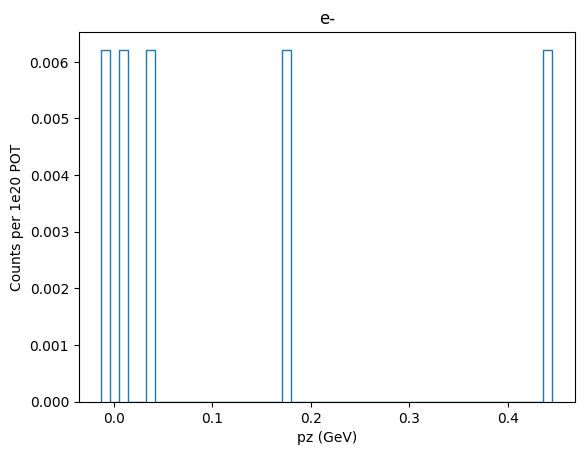

In [126]:
pdg_to_plot = 11 # Electron PDG code
variable_to_plot = 'pz'  # Choose from px, py, pz, E, m
if_duplicates = 'subleading' # Options 'leading', 'subleading', 'both'


var_list = []
for event in df['Event'].unique():
    event_df = df[df['Event'] == event]
    particles = event_df[event_df['PDG code'].abs() == int(pdg_to_plot)]
    n_particles = len(particles)
    if n_particles == 1:
        particle_value = particles[variable_to_plot].values[0]
        var_list.append(float(particle_value))
    elif n_particles > 1:
        if if_duplicates == 'both':
            for index, row in particles.iterrows():
                var_list.append(float(row[variable_to_plot]))
        elif if_duplicates == 'leading':
            argmaxE = particles['E'].astype(float).idxmax()
            leading_value = particles.loc[argmaxE, variable_to_plot]
            var_list.append(float(leading_value))
        elif if_duplicates == 'subleading':
            argmaxE = particles['E'].astype(float).idxmax()
            subleading_particles = particles.drop(argmaxE)
            if len(subleading_particles) > 0:
                argsubmaxE = subleading_particles['E'].astype(float).idxmax()
                subleading_value = subleading_particles.loc[argsubmaxE, variable_to_plot]
                var_list.append(float(subleading_value))

hist, bins = np.histogram(var_list, bins=50)
scale_factor = 1e20 / TOT_pot
plt.stairs(hist * scale_factor, bins)

# plt.hist(var_list, bins=50, histtype='stepfilled', alpha=0.7)
plt.xlabel(f'{variable_to_plot} (GeV)')
plt.ylabel('Counts per 1e20 POT')

particle_name = Particle.from_pdgid(pdg_to_plot).name

plt.title(f'{particle_name}')
plt.show()

## Particle Opening Angle

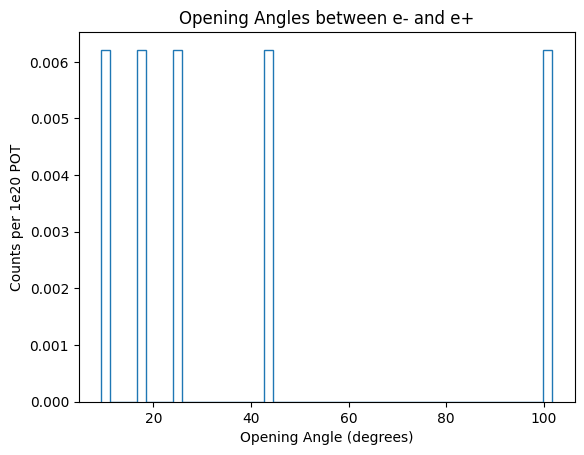

In [127]:
def calc_opening_angle(p1, p2):
    """Calculate the opening angle between two particles given their momentum vectors.

    Args:
        p1 (array-like): Momentum vector of particle 1 [px, py, pz].
        p2 (array-like): Momentum vector of particle 2 [px, py, pz].

    Returns:
        float: Opening angle in degrees.
    """
    p1 = np.array(p1)
    p2 = np.array(p2)
    dot_product = np.dot(p1, p2)
    mag_p1 = np.linalg.norm(p1)
    mag_p2 = np.linalg.norm(p2)
    cos_theta = dot_product / (mag_p1 * mag_p2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # Ensure within valid range
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def get_opening_angles(df, pdg1, pdg2):
    """Get opening angles between two particle types across all events.

    Args:
        df (pd.DataFrame): DataFrame containing event and particle data.
        pdg1 (int): PDG code of the first particle type.
        pdg2 (int): PDG code of the second particle type.

    Returns:
        list: List of opening angles in degrees.
    """
    angles = []
    for event in df['Event'].unique():
        event_df = df[df['Event'] == event]
        particles1 = event_df[event_df['PDG code'] == int(pdg1)]
        particles2 = event_df[event_df['PDG code'] == int(pdg2)]
        for _, row1 in particles1.iterrows():
            p1 = [float(row1['px']), float(row1['py']), float(row1['pz'])]
            for _, row2 in particles2.iterrows():
                p2 = [float(row2['px']), float(row2['py']), float(row2['pz'])]
                angle = calc_opening_angle(p1, p2)
                angles.append(angle)
    return angles

epem_angles = get_opening_angles(df, 11, -11)  # PDG codes for e- and e+
# plt.hist(epem_angles, bins=50, histtype='stepfilled', alpha=0.7)
hist, bins = np.histogram(epem_angles, bins=50)
scale_factor = 1e20 / TOT_pot
plt.stairs(hist * scale_factor, bins)
plt.xlabel('Opening Angle (degrees)')
plt.ylabel('Counts per 1e20 POT')
plt.title('Opening Angles between e- and e+')
plt.show()

## 2D distributions

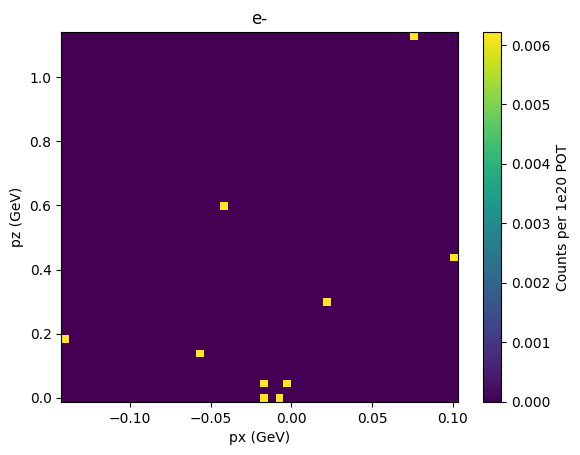

In [128]:
pdg_to_plot = 11 # Electron PDG code
variables_to_plot = ['px', 'pz'] # Choose from px, py, pz, E, m
if_duplicates = 'both' # Options 'leading', 'subleading', 'both'


var_list = []
for event in df['Event'].unique():
    event_df = df[df['Event'] == event]
    particles = event_df[event_df['PDG code'].abs() == int(pdg_to_plot)]
    n_particles = len(particles)
    if n_particles == 1:
        particle_value = particles[variables_to_plot].to_numpy()[0]
        var_list.append(particle_value)
    elif n_particles > 1:
        if if_duplicates == 'both':
            for index, row in particles.iterrows():
                var_list.append(row[variables_to_plot].to_numpy())
        elif if_duplicates == 'leading':
            argmaxE = particles['E'].astype(float).idxmax()
            leading_value = particles.loc[argmaxE, variables_to_plot].to_numpy()
            var_list.append(leading_value)
        elif if_duplicates == 'subleading':
            argmaxE = particles['E'].astype(float).idxmax()
            subleading_particles = particles.drop(argmaxE)
            if len(subleading_particles) > 0:
                argsubmaxE = subleading_particles['E'].astype(float).idxmax()
                subleading_value = subleading_particles.loc[argsubmaxE, variables_to_plot]
                var_list.append(subleading_value)


var_list = np.array(var_list)

plt.hist2d(var_list[:,0], var_list[:,1], weights=np.full(len(var_list), scale_factor), bins=50) 
plt.xlabel(f'{variables_to_plot[0]} (GeV)')
plt.ylabel(f'{variables_to_plot[1]} (GeV)')
plt.title(f'{Particle.from_pdgid(pdg_to_plot).name}')
plt.colorbar(label='Counts per 1e20 POT')
plt.show()

## Invariant Mass Plot

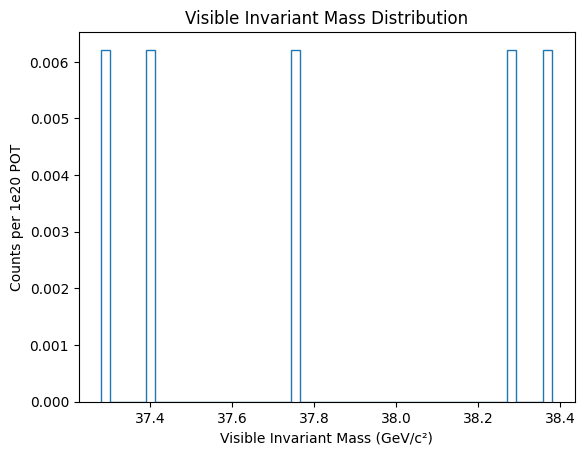

In [129]:
def calc_visible_invariant_mass(event_df):
    
    list_invisible = [
        12,
        14,
        16, 
        2112,
        111,
    ]

    E_total = 0.0
    p_tot = [0.0, 0.0, 0.0]
    final_state_mask = event_df['in/out state'] == 1
    event_df = event_df[final_state_mask]
    invis_mask = event_df['PDG code'].abs().isin(list_invisible)
    visible_particles = event_df[~invis_mask]

    E_total = visible_particles['E'].astype(float).sum()
    p_tot[0] = visible_particles['px'].astype(float).sum()
    p_tot[1] = visible_particles['py'].astype(float).sum()
    p_tot[2] = visible_particles['pz'].astype(float).sum()

    p_tot_magnitude = np.sqrt(p_tot[0]**2 + p_tot[1]**2 + p_tot[2]**2)
    M_visible_squared = E_total**2 - p_tot_magnitude**2
    M_visible = np.sqrt(M_visible_squared) if M_visible_squared > 0 else 0.0
    return M_visible

invariant_masses = []
for event in df['Event'].unique():
    event_df = df[df['Event'] == event]
    M_visible = calc_visible_invariant_mass(event_df)
    invariant_masses.append(M_visible)

# plt.hist(invariant_masses, bins=50, histtype='stepfilled', alpha=0.7)
hist, bins = np.histogram(invariant_masses, bins=50)
scale_factor = 1e20 / TOT_pot
plt.stairs(hist * scale_factor, bins)
plt.xlabel('Visible Invariant Mass (GeV/c²)')
plt.ylabel('Counts per 1e20 POT')
plt.title('Visible Invariant Mass Distribution')
plt.show()

## Interaction Vertex

Quickly check the dimensions used by roughly calculating the active argon mass - it should be around 85-87 tonnes.

In [130]:
# From the uBooNE Design paper:
#   LArTPC field cage dimensions are:
#       2.325 m vertically
#       2.560 m horizontally
#       10.368 m longitudinally
#       2.54 cm steel tude outer diameter

#   Cryostat inner dimensions are:
#       3.81m inner diameter
#       12.2m length
#       170t argon mass ?

cage_height = 2.325 # m
cage_width = 2.560  # m
cage_length = 10.368  # m

frac_height_w_lar = 0.85
cryo_diameter = 3.81  # m
cryo_length = 12.2  # m
filled_radius = cryo_diameter/2 - cryo_diameter * (1 - .85)  # m


argon_density = 1.396  # t/m3 @ 87 K 



segment_angle = np.arccos(filled_radius /(cryo_diameter/2))  # radians
a_segment = segment_angle/(2*np.pi) * np.pi * (cryo_diameter/2)**2 # m2
a_unfilled = a_segment - 2.325 * 2.560 / 4  # m2

cryo_face_area = np.pi * (cryo_diameter/2)**2  - a_unfilled # m2

vol_cryo = cryo_face_area * cryo_length  # m3
vol_fiducial = cage_height * cage_width * cage_length  # m3


mass_cryo = vol_cryo * argon_density  # t

mass_fiducial = vol_fiducial * argon_density  # t

print(f'Cryostat mass: {mass_cryo:.1f} t')
print(f'Fiducial mass: {mass_fiducial:.1f} t')

Cryostat mass: 194.9 t
Fiducial mass: 86.1 t


In [155]:
2.325/2

1.1625

In [131]:
MicroBooNEGlobalTimeOffset = 3125.0 # ns
MicroBooNERandomTimeOffset = 1600.0 # ns

n_evts = df['Event'].nunique()

### Generate random positions within the cryostat. Not using this for now,as the flux is for the active volume only.
# r = cryo_diameter / 2 

# x_rand = np.random.uniform(-r, r, 2*n_evts)
# y_rand = np.random.uniform(-r, r, 2*n_evts)
# z_rand = np.random.uniform(0, cryo_length, 2*n_evts)

# xy_mask = x_rand**2 + y_rand**2 <= r**2
# x_rand = x_rand[xy_mask][:n_evts]
# y_rand = y_rand[xy_mask][:n_evts]
# z_rand = z_rand[xy_mask][:n_evts]

x_rand = np.random.uniform(-cage_width/2, cage_width/2, n_evts)  # m
y_rand = np.random.uniform(-cage_height/2, cage_height/2, n_evts)  # m
z_rand = np.random.uniform(0, cage_length, n_evts)  # m

t_rand = MicroBooNEGlobalTimeOffset + MicroBooNERandomTimeOffset * np.random.uniform(0, 1, n_evts)  # ns

event_positions = np.column_stack((x_rand * 100, y_rand * 100, z_rand * 100, t_rand))  # shape (n_evts, 4), units cm and ns
df_positions = pd.DataFrame(event_positions, columns=['pos_scatter_1', 'pos_scatter_2', 'pos_scatter_3', 'pos_scatter_0'])
df_positions['Event'] = df['Event'].unique()
df = df.merge(df_positions, on='Event')

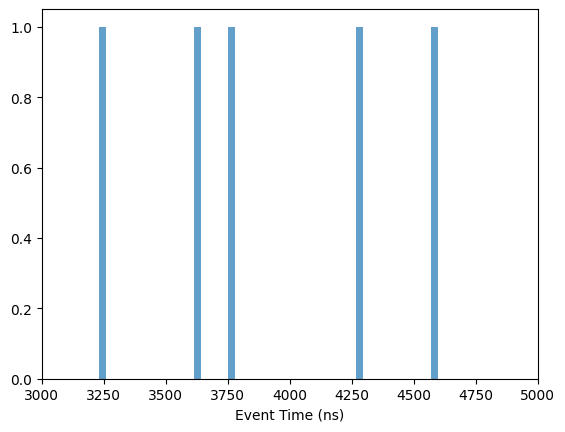

In [132]:
plt.hist(t_rand, bins=50, histtype='stepfilled', alpha=0.7)
plt.xlim(3000, 5000)
plt.xlabel('Event Time (ns)')
plt.show()

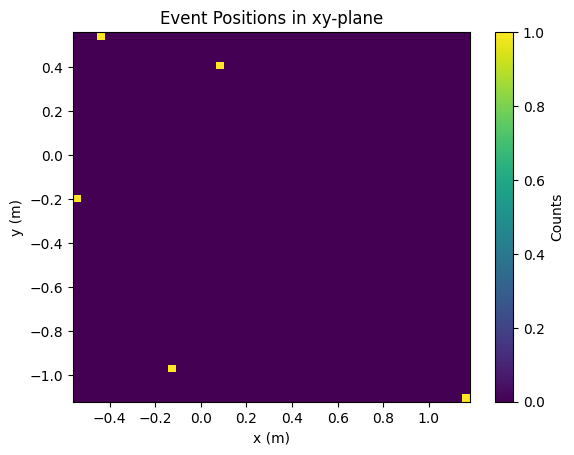

In [133]:
# xy projection

cm_per_bin = 10 # cm
yield_range = cage_length
x_range = cage_width

n_bins_x = int((x_range * 100) / cm_per_bin)
n_bins_y = int((yield_range * 100) / cm_per_bin)
plt.hist2d(x_rand, y_rand, bins=[n_bins_x, n_bins_y])

plt.hist2d(x_rand, y_rand, bins=50)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Event Positions in xy-plane')
plt.colorbar(label='Counts')
plt.show()

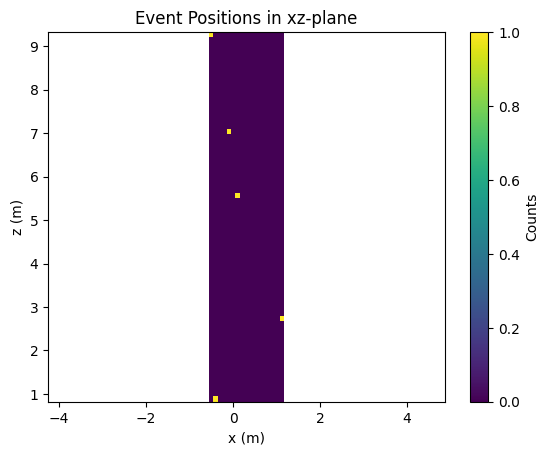

In [134]:
# xz projection
cm_per_bin = 15 # cm
z_range = cage_length
x_range = cage_width

n_bins_x = int((x_range * 100) / cm_per_bin)
n_bins_z = int((z_range * 100) / cm_per_bin)

plt.hist2d(x_rand, z_rand, bins=[n_bins_x, n_bins_z])
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Event Positions in xz-plane')
plt.colorbar(label='Counts')
plt.axis('equal')
plt.show()

# POT Calculation

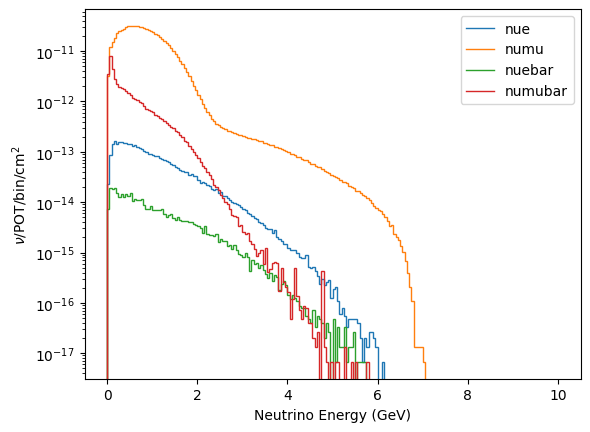

In [135]:
import uproot
# From /pnfs/uboone/persistent/uboonebeam/bnb_gsimple/bnb_gsimple_fluxes_01.09.2019_463_hist/readme.txt:
#       
#       To normalize to nu/POT/bin/cm2 apply the scale factor:
#       scale_factor=1/(4997.*5e8)/(256.35*233.);

barn = 1e-28 # m2
fbarn = 1e-15*barn # m2
fbarn = fbarn * 1e4 # cm2

nu_flavour = 'numu' # PDG code for nu_mu

flux_file = uproot.open('data/flux/bnb/MCC9_FluxHist_volTPCActive_wparent.root')

flux_dict = {}

for flavour in ['nue', 'numu', 'nuebar', 'numubar']:
    hist = flux_file[f'hE{flavour}_cv']

    # Normalisation scale factor
    sf = 1/(4997.*5e8)/(256.35*233.)
    values = hist.values() *  sf  # units: nu/POT/bin/cm2
    flux_dict[flavour] = values
    edges = hist.axis().edges()
    plt.stairs(values, edges, label=f'{flavour}')

flux_dict['bins'] = edges
plt.legend()
plt.yscale('log')
plt.xlabel('Neutrino Energy (GeV)')
plt.ylabel(r'$\nu$/POT/bin/cm$^{2}$')
plt.show()


In [136]:
cross_section_dict = {
    'nue > nue e+ e-': [0.00194201, 4.14222e-06],  # fbarn
    'numu > nue e+ mu-': [0.000493045, 3.18168e-07],  # fbarn
    'numu > numu e+ e-': [0.000313885, 1.00487e-06],  # fbarn
    'numu > numu mu+ mu-': [2.20805e-05, 1.15861e-08],  # fbarn
}

exposure = 1.32e21  # POT
M_Ar = 86e3 # kg of argon in the fiducial volume
m_Ar = 39.95 # g/mol
N_A = 6.022e23  # atoms/mol
N_targets = (M_Ar * 1e3 / m_Ar) * N_A  # number of argon atoms
for key, cross_sections in cross_section_dict.items():
    # incoming flavour from key
    flavour = key.split(' > ')[0]

    values = flux_dict[flavour]
    print(f'Calculating for process: {key}')

    N_per_pot_per_cm2 = np.sum(values)
    xsec, xsec_err = cross_sections
    xsec_cm2 = xsec * fbarn  # convert to cm2
    xsec_err_cm2 = xsec_err * fbarn  # convert to cm2
    interaction_rate = N_per_pot_per_cm2 * exposure * N_targets * xsec_cm2
    rate_uncertainty = interaction_rate * (xsec_err_cm2 / xsec_cm2) if xsec_err_cm2 else 0.0
    print(f'Process: {key}')
    print(f'  Expected Interactions: {interaction_rate:.3} ± {rate_uncertainty:.3}')
    # print(f'  Expected POT per interaction: {exposure/interaction_rate:.3} ± {exposure/interaction_rate * rate_uncertainty/interaction_rate:.3}\n')


Calculating for process: nue > nue e+ e-
Process: nue > nue e+ e-
  Expected Interactions: 0.0132 ± 2.82e-05
Calculating for process: numu > nue e+ mu-
Process: numu > nue e+ mu-
  Expected Interactions: 0.622 ± 0.000402
Calculating for process: numu > numu e+ e-
Process: numu > numu e+ e-
  Expected Interactions: 0.396 ± 0.00127
Calculating for process: numu > numu mu+ mu-
Process: numu > numu mu+ mu-
  Expected Interactions: 0.0279 ± 1.46e-05


# HEPMC Formatting

In [148]:
import pyhepmc

def write_df_as_hepmc(df, output_filename):
    writer = pyhepmc.WriterAscii(output_filename)

    for event_id in df['Event'].unique():
        event_df = df[df['Event'] == event_id]
        # Create event with units: GeV for momentum, cm for length
        hepmc_event = pyhepmc.GenEvent(pyhepmc.Units.GEV, pyhepmc.Units.CM)
        hepmc_event.event_number = int(event_id)

        # Get vertex position from first particle (all particles in event have same vertex)
        first_row = event_df.iloc[0]
        truth_vtx_x = float(first_row['pos_scatter_1'])
        truth_vtx_y = float(first_row['pos_scatter_2'])
        truth_vtx_z = float(first_row['pos_scatter_3'])
        truth_vtx_t = float(first_row['pos_scatter_0'])
        
        # Create single interaction vertex for this event
        vertex = pyhepmc.GenVertex(
            pyhepmc.FourVector(truth_vtx_x, truth_vtx_y, truth_vtx_z, truth_vtx_t)
        )
        hepmc_event.add_vertex(vertex)

        # Add all particles to the same vertex
        for _, row in event_df.iterrows():
            pdg_id = int(row['PDG code'])
            status = int(row['in/out state'])
            px = float(row['px'])
            py = float(row['py'])
            pz = float(row['pz'])
            E = float(row['E'])
            m = float(row['m'])

            particle = pyhepmc.GenParticle(
                pyhepmc.FourVector(px, py, pz, E),
                pdg_id,
                status
            )
            
            # Add incoming particles (status < 0) as inputs to vertex
            # Add outgoing particles (status > 0) as outputs from vertex
            if status < 0:
                vertex.add_particle_in(particle)
            else:
                vertex.add_particle_out(particle)

        writer.write_event(hepmc_event)

    writer.close()

output_hepmc_filename = 'output.hepmc'
write_df_as_hepmc(df, output_hepmc_filename)

/tmp/ipykernel_2540580/1294306747.py:4: DeprecationWarning: importing WriterAscii from pyhepmc is deprecated, please import from pyhepmc.io
  writer = pyhepmc.WriterAscii(output_filename)


In [174]:
with pyhepmc.open('temp.hepmc') as f:
    event = f.read()

event

<GenEvent momentum_unit=1, length_unit=1, event_number=0, particles=6, vertices=1, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

# DarkNews

In [143]:
from DarkNews import GenLauncher

kwargs = {  
        'neval': 1e3,
        'HNLtype': 'dirac',
        'hepmc3': True,
        # 'hepevt': True,
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'experiment': 'microboone',
        'nopelastic': True,
        'pandas': False,
        'loglevel': 'WARNING'
        }

gen_object = GenLauncher(mzprime=0.030, m4=0.150, **kwargs)
gen_object.run(overwrite_path='./')
dn_df = gen_object.df

Directory tree for this run already exists. Overriding it.


In [154]:
with pyhepmc.open('hep_ascii.hepmc3') as f:
    event = f.read()

event

<GenEvent momentum_unit=1, length_unit=1, event_number=0, particles=7, vertices=2, run_info=GenRunInfo(tools=[ToolInfo(name='DarkNews', version='0.4.7', description='DarkNews upscattering engine')], weight_names=['w_decay_rate_0', 'w_decay_rate_1', 'w_event_rate', 'w_flux_avg_xsec'], attributes={})>